In [1]:
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm

import sys
sys.path.append('../functions/')

import plot_params

from matplotlib.colors import LogNorm
from ts_plot import *

import date_conversions as dc

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# read in the mat file from the Geomar toolbox processed Slocum data and save as netcdf

In [3]:
%run process-slocum-mat-to-nc.py

/Users/xduplm/Library/CloudStorage/GoogleDrive-marceldpl10@gmail.com/My Drive/projects/2023_duplessis_storms_fluxes/duplessis-storms-warming/duplessis-storms-warming/code/processing


100%|██████████| 980/980 [01:09<00:00, 14.01it/s] 


<xarray.Dataset>
Dimensions:      (time: 6979677, profile: 980)
Coordinates:
  * time         (time) float64 7.374e+05 7.374e+05 ... 7.375e+05 7.375e+05
  * profile      (profile) float64 1.0 2.0 3.0 4.0 ... 977.0 978.0 979.0 980.0
Data variables:
    chlorophyll  (time) float64 0.1064 0.4964 0.8863 1.276 ... nan nan nan nan
    latitude     (time) float64 -54.01 -54.01 -54.01 ... -54.01 -54.01 -54.01
    longitude    (time) float64 0.0007786 0.0007764 ... 0.04202 0.04203
    pressure     (time) float64 nan nan nan nan ... -0.1146 -0.1257 -0.1368
    salinity     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    temperature  (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    dive         (time) float64 0.0 0.0 0.0 0.0 0.0 ... 489.5 489.5 489.5 489.5
    u            (profile) float64 0.148 -0.01497 -0.01499 ... 0.105 0.1258
    v            (profile) float64 0.1515 0.008567 ... -0.08515 -0.06107
Attributes:
    description:  Slocum dataset with raw vari

In [4]:
# read the wave glider and the mixing data sets

ep = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/duplessis-storms-paper/slocum/slocum_eps_ds_processed_era5_23Sep2022.nc')
wg = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/duplessis-storms-paper/waveglider/WG_era5_1h_processed_28Aug2022.nc')

xld = pd.read_csv('/Users/xduplm/Google Drive/My Drive/data/duplessis-storms-paper/slocum/mixing_layer_xld.csv')

xld = xr.Dataset(data_vars=dict(
                                   xld = (['time'], xld.xld.values)),                   
                    coords=dict(
                                time = (['time'], xld.Date.values.astype('datetime64[ns]'))),                   
                    attrs=dict(
                               description="Processed Slocum glider XLD data."))

xld = xld.isel(time=xld.xld>0)

# determine the day of year variable for hte various datasets

import matplotlib.dates as mdates

day0=mdates.date2num(np.datetime64('2019-01-01 00:00:00'))

ep['DOY']=(('time'), mdates.date2num(ep.TIME)-day0)
xld['DOY']=(('time'), mdates.date2num(xld.time)-day0)


In [31]:
xld.to_netcdf('../../../data/slocum/slocum_xld.nc')

In [32]:
ep.to_netcdf('../../../data/slocum/slocum_epsilon.nc')

In [5]:
# load the raw slocum glider data

sl = xr.open_dataset('../../../data/slocum/slocum_processed.nc').load()

Original size of the dataset: 6979677

In [6]:
# remove pressure and temeprature values that are below -5 (erroneous data)

variable = ['pressure', 'temperature']

threshold = -5

for v in variable:

    original_size = sl.time.size

    sl = sl.isel(time = sl[v].data > threshold)

    new_size = sl.time.size

    print(v, 'removed', original_size - new_size, 'data points')

pressure removed 4199 data points
temperature removed 287377 data points


Make the date into `datetime64` format

In [7]:
sl['time'] = (('time'), dc.matdate2pydate(sl['time'].data))

/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_3376/739887292.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  sl['time'] = (('time'), dc.matdate2pydate(sl['time'].data))
/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_3376/739887292.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 va

In [10]:
# determine the day of year variable for hte various datasets

import matplotlib.dates as mdates

day0=mdates.date2num(np.datetime64('2019-01-01 00:00:00'))

sl['DOY']=(('time'), mdates.date2num(sl.time)-day0)

In [ ]:
# calculate depth from the pressure data

import gsw

sl['depth'] = (('time'), -gsw.z_from_p(sl['pressure'].data, lat=sl['latitude'].data))

In [22]:
# save the data as a netcdf

sl.to_netcdf('../../../data/slocum/slocum_processed_L2.nc')

In [10]:
# CALCULATE THE SLOCUM SEA SURFACE TEMPERATURE

In [11]:
# check the minimum depth each profile reached so we can see which depth to use to get the slcoum sst value

In [12]:
min_dpt = np.ndarray([np.unique(sl['dive']).size])

for i, d in enumerate(np.unique(sl['dive'].data)):

    min_dpt[i] = sl.isel(time = sl['dive']==d).pressure.min()

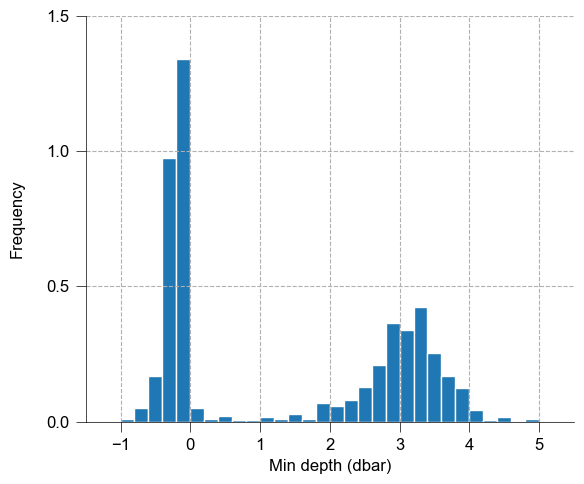

In [13]:
fig,ax=plt.subplots(figsize=(6,5))

ax.hist(min_dpt, bins=np.arange(-5, 5.2, 0.2), density=True, edgecolor='w')

ax.set_xlabel('Min depth (dbar)')

ax.set_ylabel('Frequency', labelpad=15)

ax.set_ylim(0, 1.5)

ax.set_xlim(-1.5, 5.5)

ax.yaxis.set_ticks([0, 0.5, 1, 1.5])

ax.grid(ls='--')

fig.tight_layout()

In [16]:
# filter out profles where there is no data within the top 10 m

condition = sl['depth'] < 10

# Use .where() to create a new xarray object based on the condition
sl_ = sl.isel(time=condition)

In [17]:
# how many dives remain?

for i in range(1, 11):

    condition = sl['depth'] < i

    sl_ = sl.isel(time=condition)

    print('Profile with data above', str(i),  'm - dives left:', np.unique(sl_.dive).size, 'out of', np.unique(sl.dive).size, '-', np.round(100*np.unique(sl_.dive).size/np.unique(sl.dive).size, 2), '%')
    

Profile with data above 1 m - dives left: 470 out of 910 - 51.65 %
Profile with data above 2 m - dives left: 493 out of 910 - 54.18 %
Profile with data above 3 m - dives left: 651 out of 910 - 71.54 %
Profile with data above 4 m - dives left: 874 out of 910 - 96.04 %
Profile with data above 5 m - dives left: 888 out of 910 - 97.58 %
Profile with data above 6 m - dives left: 906 out of 910 - 99.56 %
Profile with data above 7 m - dives left: 908 out of 910 - 99.78 %
Profile with data above 8 m - dives left: 908 out of 910 - 99.78 %
Profile with data above 9 m - dives left: 908 out of 910 - 99.78 %
Profile with data above 10 m - dives left: 908 out of 910 - 99.78 %


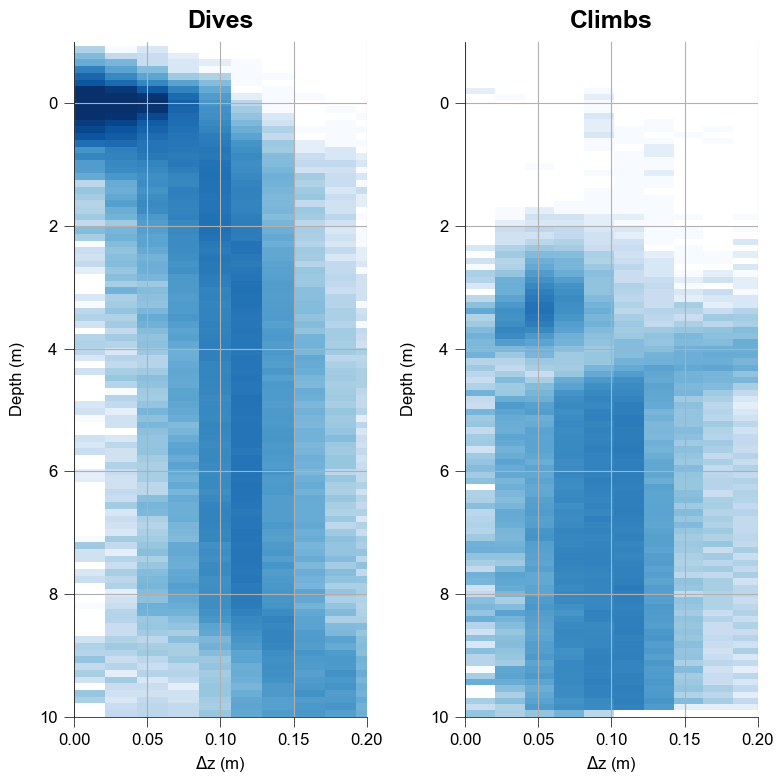

In [18]:
fig,ax=plt.subplots(1, 2, figsize=(8, 8))

sl_dive  = sl_.isel(time=sl_.dive.data % 1 == 0.0) # even -> downcast
sl_climb = sl_.isel(time=sl_.dive.data % 1 == 0.5) # odd -> upcast

x_d = np.abs(sl_dive.depth.diff(dim='time'))
y_d = sl_dive.depth[1:]

x_c = np.abs(sl_climb.depth.diff(dim='time'))
y_c = sl_climb.depth[1:]

h, xedges, yedges, im = ax[0].hist2d(x_d, y_d, bins=(500, 100), cmap='Blues', norm=LogNorm(vmin=1, vmax=1e3))

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
h, xedges, yedges, im = ax[1].hist2d(x_c, y_c, bins=(500, 100), cmap='Blues', norm=LogNorm(vmin=1, vmax=1e3))

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

for a in ax:
    
    a.set_xlim(0, 0.2)
    a.set_ylim(10, -1)

    a.set_xlabel('$\Delta$z (m)')
    a.set_ylabel('Depth (m)', labelpad=10)
    
    a.grid()

ax[0].set_title('Dives', pad=10, fontweight='bold', fontsize=18)
ax[1].set_title('Climbs', pad=10, fontweight='bold', fontsize=18)

fig.tight_layout()

In [19]:
# to find the sst value, find the median value of temperature within the top 10 m

In [20]:
condition = ((sl_['depth'] < 10) & (sl_['depth'] > 0.5))

# Use .where() to create a new xarray object based on the condition
data = sl_.sel(time=condition)

dive_no = np.array([])
sl_sst_med = np.array([])
sl_sst = np.array([])
num_n = np.array([])
lat = np.array([])
lon = np.array([])
time = np.array([], dtype='datetime64[ns]')

for i, d in enumerate(np.unique(sl_.dive.data)):

    dive = data.isel(time=data.dive==d)

    dive_no    = np.append(dive_no, d)
    sl_sst_med = np.append(sl_sst_med, np.nanmedian(dive.temperature.data))
    num_n      = np.append(num_n, len(dive.temperature.data))
    sl_sst     = np.append(sl_sst, dive.temperature.data[0])
    time       = np.append(time, dive.time.min())
    lon        = np.append(lon, np.nanmedian(dive.longitude.data))
    lat        = np.append(lat, np.nanmedian(dive.latitude.data))


In [24]:
xld

<xarray.Dataset>
Dimensions:  (time: 786)
Coordinates:
  * time     (time) datetime64[ns] 2018-12-19T21:39:40 ... 2019-03-08T09:37:55
Data variables:
    xld      (time) float64 43.35 44.75 45.0 45.0 ... 109.8 130.7 91.72 41.03
    DOY      (time) float64 -12.1 -12.01 -11.92 -11.83 ... 66.08 66.18 66.3 66.4
Attributes:
    description:  Processed Slocum glider XLD data.

In [26]:
# save the data as a netcdf

sst = xr.Dataset({
                  'dive_no': ('time', dive_no),
                  'sst': ('time', sl_sst_med),
                  'num_n': ('time', num_n), 'lat': ('time', lat), 'lon': ('time', lon)
              }, coords={'time': time})


# determine the day of year variable for hte various datasets

import matplotlib.dates as mdates

day0=mdates.date2num(np.datetime64('2019-01-01 00:00:00'))

sst['DOY']=(('time'), mdates.date2num(sst.time)-day0)

# Print the resulting xarray dataset
print(sst)

sst = sst.sel(time=slice(xld.time[0].data, xld.time[-1].data))

sst.to_netcdf('../../../data/slocum/slocum_sst_median_10m.nc')

<xarray.Dataset>
Dimensions:  (time: 908)
Coordinates:
  * time     (time) datetime64[ns] 2018-12-13T15:50:13.999000 ... 2019-03-09T...
Data variables:
    dive_no  (time) float64 0.0 0.5 1.0 1.5 2.0 ... 488.0 488.5 489.0 489.5
    sst      (time) float64 0.6492 0.6312 0.6173 0.4961 ... 2.02 2.019 2.02
    num_n    (time) float64 80.0 46.0 88.0 38.0 74.0 ... 88.0 38.0 77.0 43.0
    lat      (time) float64 -54.01 -53.99 -53.99 -53.97 ... -54.01 -54.01 -54.01
    lon      (time) float64 0.0006702 0.03927 0.03726 ... 0.04158 0.04114
    DOY      (time) float64 -18.34 -18.19 -18.16 -18.0 ... 67.24 67.25 67.26
